## **Setup**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from seaborn import kdeplot
import gc
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from IPython.display import display
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
path = "./"

train_ori = pd.read_csv(path + 'train.csv')
test_ori  = pd.read_csv(path + 'test.csv')
sample = pd.read_csv(path + 'sample_submission.csv')

## **EDA**

In [19]:
train_ori.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [ ]:
common_features = ['breath_id','R','C','time_step','u_in','u_out']
numerical_features = ['time_step','u_in']
categorical_features = ['R','C','u_out','breath_id']

def kdeplot_features(df_train,df_test, feature, title):
    '''Takes a column from the dataframe and plots the distribution (after count).'''
    
    values_train = df_train[feature].to_numpy()
    values_test = df_test[feature].to_numpy()  
    plt.figure(figsize=(18,3), facecolor=(17/255,17/255,17/255, 1))
    sns.kdeplot(values_train, color = '#ffd514')
    sns.kdeplot(values_test, color = '#ff355d')
    plt.legend()
    plt.title(title, fontsize=15, color='white')
    ax = plt.gca()
    ax.set_facecolor((17/255,17/255,17/255, 1))
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    plt.savefig(f'./Presentation/RevealJsMaterial/Visualizations/{feature}.jpg')
    plt.show();
    del values_train , values_test
    gc.collect()

for feature in common_features:
    kdeplot_features(train_ori,test_ori, feature=feature, title = feature + " distribution")

___________



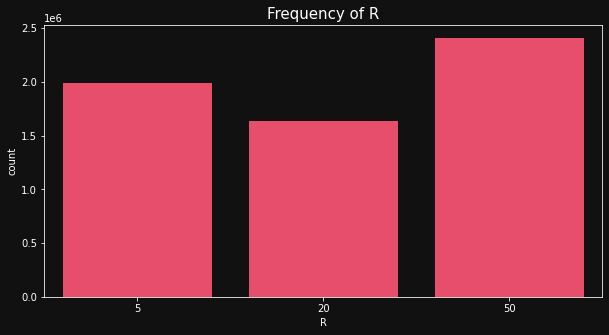

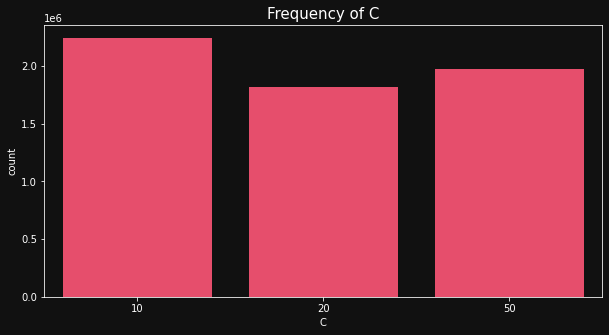

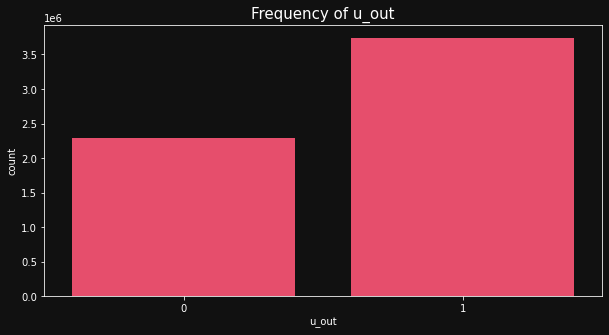

In [17]:
def countplot_features(df_train, feature, title):
    '''Takes a column from the dataframe and plots the distribution (after count).'''
    plt.figure(figsize = (10, 5),facecolor=(17/255,17/255,17/255, 1))
    sns.countplot(df_train[feature], color = '#ff355d')
    plt.title(title, fontsize=15, color='white')    
    ax = plt.gca()
    ax.set_facecolor((17/255,17/255,17/255, 1))
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    plt.savefig(f'./Presentation/RevealJsMaterial/Visualizations/Count_{feature}.jpg')
    plt.show();
    
for feature in categorical_features[:-1]:
    countplot_features(train_ori, feature=feature, title = "Frequency of "+ feature)

In [7]:
train_ori["seq"] = train_ori.groupby(["breath_id"])["id"].cumcount()
test_ori["seq"] = test_ori.groupby(["breath_id"])["id"].cumcount()

In [10]:
train_ori["pressure"] = np.around (train_ori["pressure"].values, decimals=4)
             
base = train_ori.drop_duplicates (subset=["R","C","pressure"])[["R","C", "pressure"]]
sns.set(font_scale=1.2)
for seq in range(80):
    train_seq = train_ori.query("seq == @seq")
    time = train_seq["time_step"].mean()
    df = train_seq.groupby (["R","C","pressure"]).agg({"id":"count"}).reset_index()
    df = df.append (base)
    df = df.groupby (["R","C","pressure"]).agg({"id":"sum"}).reset_index()
    df["log1p_id"] = np.log1p(df["id"])
    heat_map = df.pivot(index=["R","C"], columns="pressure", values="log1p_id").fillna(0)
    fig = plt.figure ( figsize=(15,5) )
    g=sns.heatmap(heat_map, vmin=0, vmax=7, xticklabels=30, cbar_kws={'label': 'log1p(count)'}, cmap="YlGnBu")
    plt.text(670.0, 0.7, f"frame: {seq}, time: {time:.2f}", horizontalalignment='left', size='large', color='white', weight='semibold')
    plt.tight_layout()
    plt.savefig(f'./Frames/frame{seq:05d}.jpg')
    plt.close(fig)

In [11]:
# !ffmpeg -y -framerate 15  -i ./frame%5d.jpg  ../Presentation/output.mp4

In [4]:
from IPython.display import HTML

HTML("""
    <video alt="test" loop autoplay>
        <source src="./Presentation/RevealJsMaterial/output.mp4" type="video/mp4">
    </video>
""")


## **Feature Engineering**

In [ ]:
def add_features(df):
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['RC']= df['R'] + df['C']
    df['u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['u_in_lag'] = df['u_in_lag'] * df['breath_id_lagsame']
    df['u_in_lag2']= df['u_in'].shift(2).fillna(0)
    df['u_in_lag2']= df['u_in_lag2']*df['breath_id_lag2same']
    df['u_out_lag2']= df['u_out'].shift(2).fillna(0)
    df['u_out_lag2']= df['u_out_lag2']*df['breath_id_lag2same']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['cross'] = df['u_in'] * df['u_out']
    df['cross2']=df['time_step'] * df['u_out']
    df['breath_id_lag']  = df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2'] = df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame'] = np.select([df['breath_id_lag']==df['breath_id']], [1], 0)
    df['breath_id_lag2same']= np.select([df['breath_id_lag2']==df['breath_id']], [1], 0)
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['one']  = 1
    df['count']= (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] = df['u_in_cumsum'] / df['count']
    df = pd.get_dummies(df)
    return df
train = add_features(train_ori)
test  = add_features(test_ori)

In [ ]:
del train_ori
del test_ori

In [ ]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)
train.drop(['pressure','id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2'], axis=1, inplace=True)
test = test.drop(['id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2'], axis=1)

print('')

In [ ]:
# This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

RS = RobustScaler()
train = RS.fit_transform(train)
test = RS.transform(test)

In [ ]:
train = train.reshape(-1, 80, train.shape[-1])
test  = test.reshape(-1, 80, train.shape[-1])

In [ ]:
train.shape, test.shape

((75450, 80, 25), (50300, 80, 25))

In [ ]:
gc.collect()

148

In [ ]:
EPOCH = 300
BATCH_SIZE = 512
FOLDS = 6
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

with tpu_strategy.scope():
    kf = KFold(n_splits = FOLDS, shuffle=True, random_state=2021)
    test_preds = []
    
    for fold, (trn_idx, val_idx) in enumerate(kf.split(train, targets)):
        print('-'*15, '>', f"Fold {fold+1}", '<', '-'*15)
        
        xtrain, xvalid = train[trn_idx], train[val_idx]
        ytrain, yvalid = targets[trn_idx], targets[val_idx]
        
        model = keras.models.Sequential([
            keras.layers.Input(shape=train.shape[-2:]),
            keras.layers.Bidirectional(keras.layers.LSTM(450, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(350, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(250, return_sequences=True)),
            keras.layers.Bidirectional(keras.lazyers.LSTM(150, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True)),
            keras.layers.Dense(50, activation='selu'),
            keras.layers.Dense(1),
        ])
        
        model.compile(optimizer="adam", loss="mae")
        
        scheduler = ExponentialDecay(1e-3, 400*((len(train)*0.8)/BATCH_SIZE), 1e-5)
        lr = LearningRateScheduler(scheduler, verbose=1)
        
        model.fit(xtrain, ytrain,
                  validation_data=(xvalid, yvalid),
                  epochs=EPOCH,
                  batch_size=BATCH_SIZE,
                  callbacks=[lr]
                 )
        test_preds.append(model.predict(test).squeeze().reshape(-1, 1).squeeze())
    

2021-10-09 19:46:29.520749: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-09 19:46:29.524281: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-09 19:46:29.524319: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-09 19:46:29.524357: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (931e7ab98537): /proc/driver/nvidia/version does not exist
2021-10-09 19:46:29.527761: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

--------------- > Fold 1 < ---------------
Epoch 1/300

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
123/123 [==============================] - 44s 180ms/step - loss: 3.8414 - val_loss: 1.1251
Epoch 2/300

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009997559, shape=(), dtype=float32).
123/123 [==============================] - 10s 78ms/step - loss: 1.0882 - val_loss: 0.7695
Epoch 3/300

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009995119, shape=(), dtype=float32).
123/123 [==============================] - 9s 76ms/step - loss: 0.7749 - val_loss: 0.7462
Epoch 4/300

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009992679, shape=(), dtype=float32).
123/123 [==============================] - 9s 76ms/step - loss: 0.7228 - val_loss: 0.5991
Epoch 5/300

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990239, shape=(

In [ ]:
output = pd.read_csv(path + 'sample_submission.csv')
output.pressure = sum(test_preds) / FOLDS
output.to_csv('submission.csv', index=False)

In [ ]:
test['pressure'] = submission['pressure']

In [ ]:
test["seq"] = test.groupby(["breath_id"])["id"].cumcount()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
test["pressure"] = np.around (test["pressure"].values, decimals=1)
             
base = test.drop_duplicates (subset=["R","C","pressure"])[["R","C", "pressure"]]
sns.set(font_scale=1.2)
for seq in range(80):
    train_seq = test.query("seq == @seq")
    time = train_seq["time_step"].mean()
    df = train_seq.groupby (["R","C","pressure"]).agg({"id":"count"}).reset_index()
    df = df.append (base)
    df = df.groupby (["R","C","pressure"]).agg({"id":"sum"}).reset_index()
    df["log1p_id"] = np.log1p(df["id"])
    heat_map = df.pivot(index=["R","C"], columns="pressure", values="log1p_id").fillna(0)
    fig = plt.figure ( figsize=(15,5) )
    g=sns.heatmap(heat_map, vmin=0, vmax=7, xticklabels=30, cbar_kws={'label': 'log1p(count)'}, cmap="Greens",)
    g.set(xlabel=None)
    plt.text(670.0, 0.7, f"frame: {seq}, time: {time:.2f}", horizontalalignment='left', size='large', color='white', weight='semibold')
    plt.tight_layout()
    plt.savefig(f'./OutputFrames/frame{seq:05d}.jpg')
    plt.close(fig)

In [ ]:
# !ffmpeg -y -framerate 15  -i ./frame%5d.jpg  ../Presentation/output.mp4